In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install folium
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

In [2]:
## Columns to keep from data base
demigraphic = ['sitecode','year','age','sex','race4','race7','stheight','stweight','bmi']
life_style = ['qnfr1','qnveg1','qnsoda1','qnmilk1','qnbk7day','qnpa0day','qnpa7day']
## TODO: Maybe include data point weighting??
## TODO: Maybe extend list of kept columns
cols = demigraphic+life_style

## List of dataframes of data points sampled from each state in 2017
data_sample_2017 = []

In [3]:
## Reads in data from states A-M, dropping unnecessary columns and null rows
yrbs_a_m = pd.read_csv('databases/states_a-m1.csv')[cols].dropna(subset=['bmi'])
## NOTE: Dropping null rows removed entire states from data set
## TODO: Look into reasoning

## Get 2017 data only
yrbs_a_m = yrbs_a_m[yrbs_a_m.year == 2017]

yrbs_a_m.head()

,sitecode,year,age,sex,race4,race7,stheight,stweight,bmi,qnfr1,qnveg1,qnsoda1,qnmilk1,qnbk7day,qnpa0day,qnpa7day
418579,AK,2017.0,3.0,NaN,3.0,4.0,NaN,NaN,182.405507,2.0,2.0,1.0,NaN,NaN,1.0,2.0
418580,AK,2017.0,3.0,NaN,1.0,6.0,NaN,NaN,19.285006,2.0,1.0,2.0,NaN,NaN,2.0,2.0
418581,AK,2017.0,6.0,NaN,4.0,7.0,NaN,NaN,25.160156,1.0,2.0,2.0,NaN,NaN,2.0,2.0
418582,AK,2017.0,NaN,2.0,4.0,1.0,NaN,NaN,22.796202,1.0,1.0,1.0,NaN,NaN,2.0,1.0
418583,AK,2017.0,NaN,2.0,4.0,7.0,NaN,NaN,16.964207,1.0,1.0,1.0,NaN,NaN,2.0,2.0


In [4]:
## Samples 1000 data points from each state A-M
states_a_m = yrbs_a_m['sitecode'].unique()

for state in states_a_m:
    ## Not all states have 1000 data points
    ## In the case of <= 1000, all points are sampled
    if yrbs_a_m[:][yrbs_a_m.sitecode == state].shape[0] > 1000:
        data_sample_2017.append(yrbs_a_m[:][yrbs_a_m.sitecode == state].sample(1000))
    else:
        data_sample_2017.append(yrbs_a_m[:][yrbs_a_m.sitecode == state])

del yrbs_a_m, states_a_m

In [5]:
## Reads in data from states N-Z, dropping unnecessary columns and null rows
yrbs_n_z = pd.read_csv('databases/states_n-z1.csv')[cols].dropna(subset=['bmi'])
yrbs_n_z = yrbs_n_z[yrbs_n_z.year == 2017]
yrbs_n_z.head()

,sitecode,year,age,sex,race4,race7,stheight,stweight,bmi,qnfr1,qnveg1,qnsoda1,qnmilk1,qnbk7day,qnpa0day,qnpa7day
436684,NC,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,20.906250,NaN,NaN,NaN,NaN,2.0,2.0,2.0
436687,NC,2017.0,1.0,NaN,4.0,5.0,NaN,NaN,31.161654,1.0,1.0,2.0,NaN,2.0,2.0,2.0
436688,NC,2017.0,1.0,NaN,4.0,1.0,NaN,NaN,21.215986,2.0,1.0,1.0,NaN,2.0,1.0,2.0
436691,NC,2017.0,3.0,NaN,NaN,NaN,NaN,NaN,35.790935,2.0,2.0,2.0,NaN,2.0,1.0,2.0
436692,NC,2017.0,4.0,NaN,NaN,NaN,NaN,NaN,29.349198,1.0,1.0,1.0,NaN,2.0,2.0,2.0


In [6]:
## Samples 1000 data points from each states N-Z
states_n_z = yrbs_n_z['sitecode'].unique()

for state in states_n_z:
    if yrbs_n_z[:][yrbs_n_z.sitecode == state].shape[0] > 1000:
        data_sample_2017.append(yrbs_n_z[:][yrbs_n_z.sitecode == state].sample(1000))
    else:
        data_sample_2017.append(yrbs_n_z[:][yrbs_n_z.sitecode == state])

del yrbs_n_z, states_n_z

In [7]:
## Combines all samples into one dataframe
df_2017 = pd.concat(data_sample_2017).reset_index().drop(columns={'index'})
df_2017.head()

,sitecode,year,age,sex,race4,race7,stheight,stweight,bmi,qnfr1,qnveg1,qnsoda1,qnmilk1,qnbk7day,qnpa0day,qnpa7day
0,AK,2017.0,7.0,2.0,1.0,6.0,1.85,105.69,30.880935,2.0,2.0,2.0,NaN,NaN,1.0,2.0
1,AK,2017.0,4.0,2.0,1.0,6.0,1.42,52.16,25.867883,1.0,1.0,2.0,NaN,NaN,2.0,1.0
2,AK,2017.0,5.0,2.0,4.0,2.0,1.52,53.52,23.164820,1.0,2.0,2.0,NaN,NaN,2.0,2.0
3,AK,2017.0,5.0,1.0,4.0,7.0,1.63,56.70,21.340660,1.0,1.0,2.0,NaN,NaN,2.0,1.0
4,AK,2017.0,5.0,2.0,4.0,1.0,1.70,79.38,27.467128,2.0,2.0,2.0,NaN,NaN,2.0,2.0


In [8]:
df_2017.shape
## May be able to remove conditions in sampling size, check later

(33000, 16)

In [9]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
map_2017 = folium.Map(location=[37, -102], zoom_start=3)

avg_2017 = df_2017.groupby('sitecode')['bmi'].mean().to_frame().reset_index()

folium.Choropleth(
    geo_data = state_geo,
    name = '2017 BMI',
    data = avg_2017,
    columns = ['sitecode', 'bmi'],
    key_on = 'feature.id',
    fill_color = 'YlGn',
    nan_fill_color = 'white',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'BMI'
).add_to(map_2017)

map_2017

In [10]:
## Clean data
df_2017['veg'] = np.abs(df_2017['qnveg1']-2)
df_2017['fru'] = np.abs(df_2017['qnfr1']-2)
df_2017['soda'] = np.abs(df_2017['qnsoda1']-2)
df_2017['milk'] = np.abs(df_2017['qnmilk1']-2)
df_2017['brk'] = np.abs(df_2017['qnbk7day']-2)
df_2017['act0'] = df_2017['qnpa0day']-1
df_2017['act7'] = np.abs(df_2017['qnpa7day']-2)

df_2017 = df_2017.dropna()

In [11]:
df_x = df_2017[['veg','fru','soda','milk','brk','act7']]
df_y = df_2017['bmi'].values

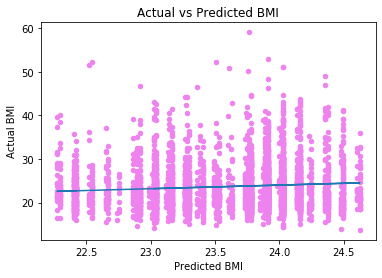

Mean Absolute Error: 3.9084261080076113
Mean Squared Error: 28.340866484043275
Root Mean Squared Error: 5.323614043489937


In [12]:
## Added variable may make it impossible to divide data, do stuff seperately
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(x_train, y_train)
coeff_df = pd.DataFrame(reg.coef_, df_x.columns, columns=['Coefficient'])
coeff_df.head(6)

y_pred = reg.predict(x_test)
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': y_pred - y_test,'val':1})
res.head(10)

ax = res.plot(kind='scatter',x='Predicted',y='Actual',color='violet',title='Actual vs Predicted BMI')
ax.set_xlabel('Predicted BMI')
ax.set_ylabel('Actual BMI')
## Calculate trend line
trend = np.polyfit(res.Predicted, res.Actual, 1)
model = np.poly1d(trend)
plt.plot(res.Predicted, model(res.Predicted))
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

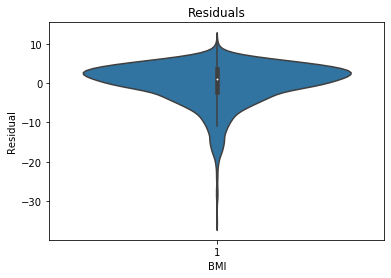

In [13]:
bx = sns.violinplot(y='Error',x='val',data=res)
bx.set_title('Residuals')
bx.set_xlabel('BMI')
bx.set_ylabel('Residual')
plt.show()

In [19]:
df_x = df_2017[['veg','fru','soda','milk','brk','act7']]
df_y = df_2017[['bmi']]
reg = LinearRegression()
cv = KFold(n_splits=10, shuffle=False)
res = []
for train_index, test_index in cv.split(df_x):
    x_train, x_test = df_x[df_x.index.isin(train_index)], df_x[df_x.index.isin(test_index)]
    y_train, y_test = df_y[df_y.index.isin(train_index)], df_y[df_y.index.isin(test_index)]
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    res.append(metrics.mean_absolute_error(y_test, y_pred))
print('Average Mean Absolute Error from 10-Fold Cross Validation:',np.mean(res))

Average Mean Absolute Error from 10-Fold Cross Validation: 3.8585494094165234


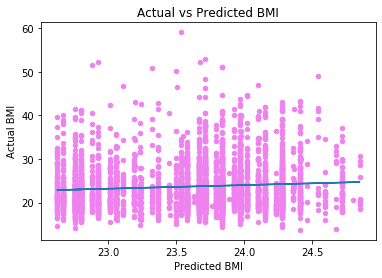

Mean Absolute Error: 3.9109175686966244
Mean Squared Error: 28.368973917202545
Root Mean Squared Error: 5.326253271972949


In [15]:
## No activity at all

df_x = df_2017[['veg','fru','soda','milk','brk','act0']]
df_y = df_2017['bmi'].values

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(x_train, y_train)
coeff_df = pd.DataFrame(reg.coef_, df_x.columns, columns=['Coefficient'])  
coeff_df.head(6)

y_pred = reg.predict(x_test)
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': y_pred - y_test})
res.head(10)

ax = res.plot(kind='scatter',x='Predicted',y='Actual',color='violet',title='Actual vs Predicted BMI')
ax.set_xlabel('Predicted BMI')
ax.set_ylabel('Actual BMI')
## Calculate trend line
trend = np.polyfit(res.Predicted, res.Actual, 1)
model = np.poly1d(trend)
plt.plot(res.Predicted, model(res.Predicted))
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [16]:
df_x = df_2017[['veg','fru','soda','milk','brk','act0']]
df_y = df_2017[['bmi']]
reg = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=False)
res = []
for train_index, test_index in cv.split(df_x):
    x_train, x_test = df_x[df_x.index.isin(train_index)], df_x[df_x.index.isin(test_index)]
    y_train, y_test = df_y[df_y.index.isin(train_index)], df_y[df_y.index.isin(test_index)]
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    res.append(metrics.mean_absolute_error(y_test, y_pred))
print('Average Mean Absolute Error from 10-Fold Cross Validation:',np.mean(res))

Average Mean Absolute Error from 10-Fold Cross Validation: 3.8614123376963625
